# 3장. 기초를 넘어서: 이미지에서 특징 감지하기

## 합성곱 신경망 만들기

In [7]:
import tensorflow as tf
data = tf.keras.datasets.fashion_mnist

(training_images, training_labels), (test_images, test_labels) = data.load_data()

training_images = training_images.reshape(60000, 28, 28, 1)
training_images = training_images / 255.0

test_images = test_images.reshape(10000, 28, 28, 1)
test_images = test_images / 255.0

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', 
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(training_images, training_labels, epochs=30)

In [ ]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.9373 - accuracy: 0.9108


[0.9373274445533752, 0.9107999801635742]

In [ ]:
classifications = model.predict(test_images)
print(classifications[0])
print(test_labels[0])

313/313 [==============================] - 1s 2ms/step
[1.0593565e-25 4.5061554e-36 4.5964984e-31 6.9855330e-35 4.2500467e-30
 2.7152591e-20 1.8340670e-32 2.8903417e-15 1.2565073e-31 1.0000000e+00]
9


## 합성곱 신경망 살펴 보기

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

## 말과 사람을 구별하는 CNN 만들기


* 합성곱과 합성곱 신경망을 확장하여
* 특징의 위치가 동일하지 않은 이미지 분류

#### 말-사람 데이터 셋
* 300x300 픽셀 이미지 수천 개를 담고 있으며,
* 여러 포즈의 말과 사람이 거의 절반씩 구성되어 있다.
* 피사체의 방향과 자세가 다르고, 이미지 구성이 제각각이다.
* 이미지에는 나무와 해변같은 배경이 포함되어 있어, 
* 분류 모델이 배경에 영향을 받지 않고,
* 말과 사람을 결정할 수 있는 중요한 특징을 찾아야 한다.

#### 1. 케라스 ImageDataGenerator
* 이미지 기반 데이터 셋 상당수는 레이블 대신 이미지가 디렉터리(폴더)에 종류별로 나눠져 있는 경우가 많다.
* 이런 디렉터리 구조를 사용하여 자동으로 이미지에 레이블을 할당할 수 잇다.

#### ImageDataGenerator 사용조건
* 레이블 이름으로 구성된 디렉터리가 필요하다

In [4]:
# 파일 다운받기

import urllib.request
import zipfile

url = "https://storage.googleapis.com/learning-datasets/horse-or-human.zip"
file_name = "horse-or-human.zip"

training_dir = 'horse-or-human/training/'
urllib.request.urlretrieve(url, file_name)

zip_ref = zipfile.ZipFile(file_name, 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator
# 디렉터리를 순회하면서 이미지를 생성하는 반복자 객체
# 객체의 flow_from_directory() 함수를 사용한다.

# 전체 이미지를 1./255로 스케일을 조정합니다.
# target_size : 가로, 세로 픽셀 / 기본값은 256x256
# class_mode : 이미지가 두 종류인 경우 (binary) / 그 이상일 경우 (categorical)

# 최신 텐서플로의 경우, tf.keras.utils.image_dataset_from_directory()
# 이 경우, ImageDataGenerator 메서드를 사용하는 대신, 모델 생성시에 Rescaling 층을 이용
# tf.keras.layers.Rescaling(1./255, input_shape=(300, 300, 3))

train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


### 말-사람 데이터셋을 위한 CNN 구조

1. 이미지가 300x300 픽셀로 크기가 크기 때문에 많은 층이 필요하다.
2. 흑백이 아니라 컬러이미지라서 채널이 하나가 아니라 세개다.
3. 두 종류의 이미지만 있으므로 출력층에 하나의 출력 뉴런을 사용하는 이진 분류기를 만들 수 있다.

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [10]:
from tensorflow.keras.optimizers import RMSprop
# optimizer RMSprop 사용
# 이진분류 : loss='binary_crossentropy'

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [11]:
model.fit(train_generator, epochs=15)

Epoch 1/15
33/33 [==============================] - 30s 875ms/step - loss: 0.6444 - accuracy: 0.6738
Epoch 2/15
33/33 [==============================] - 33s 983ms/step - loss: 0.3704 - accuracy: 0.8666
Epoch 3/15
33/33 [==============================] - 33s 989ms/step - loss: 0.2089 - accuracy: 0.9202
Epoch 4/15
33/33 [==============================] - 33s 978ms/step - loss: 0.1688 - accuracy: 0.9367
Epoch 5/15
33/33 [==============================] - 33s 978ms/step - loss: 0.1836 - accuracy: 0.9406
Epoch 6/15
33/33 [==============================] - 35s 1s/step - loss: 0.0672 - accuracy: 0.9776
Epoch 7/15
33/33 [==============================] - 38s 1s/step - loss: 0.1697 - accuracy: 0.9562
Epoch 8/15
33/33 [==============================] - 32s 966ms/step - loss: 0.1066 - accuracy: 0.9727
Epoch 9/15
33/33 [==============================] - 34s 1s/step - loss: 0.0303 - accuracy: 0.9864
Epoch 10/15
33/33 [==============================] - 39s 1s/step - loss: 0.0741 - accuracy: 0.9727
E

#### `image_dataset_from_directory` 사용하기 (텐서플로 최신 버전)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    image_size=(300, 300),
    label_mode='binary'
)

Found 1027 files belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(300, 300, 3)),   # Rescaling 층

    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=15)

Epoch 1/15
33/33 [==============================] - 6s 114ms/step - loss: 0.6009 - accuracy: 0.6631
Epoch 2/15
33/33 [==============================] - 5s 112ms/step - loss: 0.3060 - accuracy: 0.8870
Epoch 3/15
33/33 [==============================] - 5s 112ms/step - loss: 0.2603 - accuracy: 0.9172
Epoch 4/15
33/33 [==============================] - 5s 112ms/step - loss: 0.0956 - accuracy: 0.9640
Epoch 5/15
33/33 [==============================] - 5s 113ms/step - loss: 0.1749 - accuracy: 0.9611
Epoch 6/15
33/33 [==============================] - 5s 112ms/step - loss: 0.0782 - accuracy: 0.9747
Epoch 7/15
33/33 [==============================] - 5s 113ms/step - loss: 0.1548 - accuracy: 0.9718
Epoch 8/15
33/33 [==============================] - 5s 112ms/step - loss: 0.0721 - accuracy: 0.9873
Epoch 9/15
33/33 [==============================] - 5s 112ms/step - loss: 0.2042 - accuracy: 0.9649
Epoch 10/15
33/33 [==============================] - 5s 113ms/step - loss: 0.0037 - accuracy: 1.0000

### 검증 세트 추가하기

* 모델을 검증할 경우, 훈련 데이터 셋과는 별개로 검증 데이터 셋이 필요하다.
* 말-사람 데이터셋은 별도의 검증 데이터 셋을 제공하기 때문에 따로 받아서 쓸 수 있다.   

훈련 데이터 셋: 모델에 데이터와 레이블을 매핑하는 방법을 **가르치기 위해서** 사용.   
검증 데이터 셋: 모델을 훈련하는 데 쓰이지 않은 데이터로, 모델의 **성능을 평가**하는 데 사용.
테스트 데이터 셋: 훈련이 끝난 후, 훈련에 쓰이지 않은 데이터로 모델이 **얼마나 잘 작동**하는지 확인하기 위해 사용.

In [12]:
# 검증 세트 다운받기
validation_url = "https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip"

validation_file_name = "validation-horse-or-human.zip"
validation_dir = 'horse-or-human/validation/'
urllib.request.urlretrieve(validation_url, validation_file_name)

zip_ref = zipfile.ZipFile(validation_file_name, 'r')
zip_ref.extractall(validation_dir)
zip_ref.close()

In [13]:
validation_datagen = ImageDataGenerator(rescale=1/255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    class_mode='binary'
)

Found 256 images belonging to 2 classes.


In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [16]:
model.fit(train_generator,
          epochs=15,
          validation_data=validation_generator)

Epoch 1/15
33/33 [==============================] - 38s 1s/step - loss: 0.6053 - accuracy: 0.6436 - val_loss: 0.9098 - val_accuracy: 0.5312
Epoch 2/15
33/33 [==============================] - 43s 1s/step - loss: 0.3784 - accuracy: 0.8413 - val_loss: 0.7214 - val_accuracy: 0.7695
Epoch 3/15
33/33 [==============================] - 42s 1s/step - loss: 0.2106 - accuracy: 0.9241 - val_loss: 1.1346 - val_accuracy: 0.8516
Epoch 4/15
33/33 [==============================] - 40s 1s/step - loss: 0.0941 - accuracy: 0.9620 - val_loss: 0.8426 - val_accuracy: 0.8633
Epoch 5/15
33/33 [==============================] - 40s 1s/step - loss: 0.1296 - accuracy: 0.9494 - val_loss: 1.2799 - val_accuracy: 0.8125
Epoch 6/15
33/33 [==============================] - 40s 1s/step - loss: 0.0686 - accuracy: 0.9796 - val_loss: 0.5881 - val_accuracy: 0.8633
Epoch 7/15
33/33 [==============================] - 38s 1s/step - loss: 0.0612 - accuracy: 0.9864 - val_loss: 1.9121 - val_accuracy: 0.8398
Epoch 8/15
33/33 [==

### 모델 실행하기

코랩을 사용하는 경우 아래 셀에서 직접 이미지를 업로드할 수 있습니다.

In [17]:
import sys

# 코랩을 사용중인지 확인합니다.
if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()
    sample_images = ['/content/' + fn for fn in uploaded.keys()]

    # 업로드된 파일이 없으면 깃허브에서 다운로드합니다.
    if len(uploaded) < 1:
        import gdown
        base_url = 'https://github.com/rickiepark/aiml4coders/raw/main/ch03/'
        for i in range(1,4):
            gdown.download(base_url + 'hh_image_{}.jpg'.format(i))
        sample_images = ['/content/hh_image_{}.jpg'.format(i) for i in range(1,4)]

# 로컬 컴퓨터면 ch03 폴더에 있는 이미지를 사용합니다.
else:
    sample_images = ['hh_image_{}.jpg'.format(i) for i in range(1,4)]

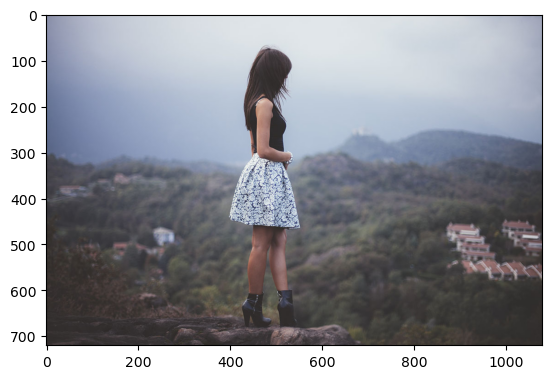

1/1 [==============================] - 0s 145ms/step
모델 출력: 1.0
hh_image_1.jpg는 사람입니다.
--------------------


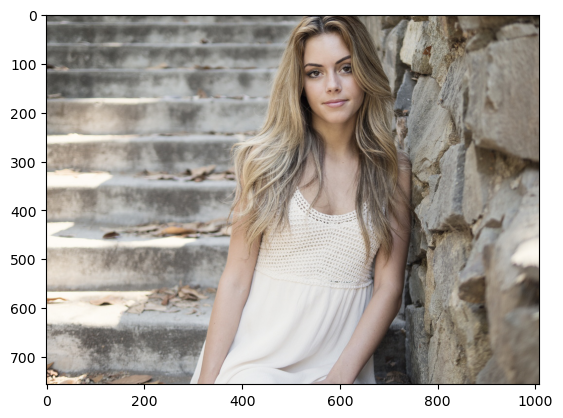

1/1 [==============================] - 0s 44ms/step
모델 출력: 0.0
hh_image_2.jpg는 말입니다.
--------------------


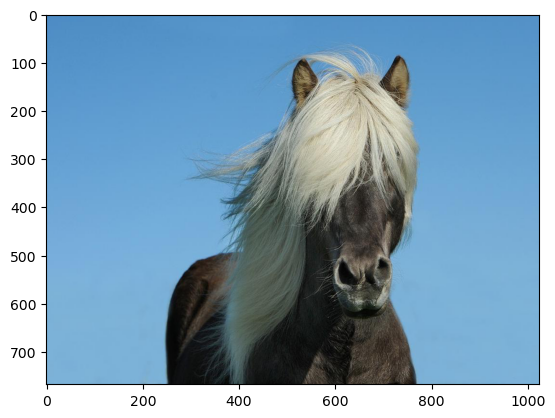

1/1 [==============================] - 0s 36ms/step
모델 출력: 0.0
hh_image_3.jpg는 말입니다.
--------------------


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image

for fn in sample_images:                                            # 이미지 리스트에서 차례로 하나씩
    # 이미지 출력: 우리 눈에 보이게
    plt.imshow(mpimg.imread(fn))
    plt.show()
    
    # 이미지 불러오기: 객체에 저장
    img = tf.keras.utils.load_img(fn, target_size=(300, 300))       # 모델에 주입하기 위해 target_size를 300 x 300으로 지정해줘야 함
    x = tf.keras.utils.img_to_array(img)                            # 이미지를 2D배열로 변환
    x = np.expand_dims(x, axis=0)                                   # 3D 배열을 넣어줘야 하므로, expand_dims 함수를 이용해 차원 추가

    classes = model.predict(x)

    print('모델 출력:', classes[0][0])
    if classes[0][0] > 0.5:
        print(fn + "는 사람입니다.")
    else:
        print(fn + "는 말입니다.")
    print('--------------------')

## 이미지 증식(Image Augmentation)
* 기존에 없던 자세의 사람이 담긴 사진을 훈련 데이터 셋에 추가
* 텐서플로에는 가상으로 데이터 셋을 확장할 수 있는 기능을 제공한다.

* 회전 / 수평이동 / 수직이동 / 기울임(Shearing) / 확대 / 반전(Flipping)

1. 자기 데이터가 모자란다.
2. 새로운 이미지를 인식하지 못한다.   
==> 그러면 이미지를 증식시켜서 다시 훈련시켜본다.

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [21]:
train_datagen = ImageDataGenerator(
    # 이미지 정규화
    rescale=1./255,
    # 다양한 변환 적용
    rotation_range=40,          # 왼쪽 또는 오른쪽으로 40도까지 랜덤하게 회전
    width_shift_range=0.2,      # 수평으로 20%까지 랜덤하게 이동
    height_shift_range=0.2,     # 수직으로 20%까지 랜덤하게 이동
    shear_range=0.2,            # 20%까지 랜덤하게 기울임
    zoom_range=0.2,             # 20%까지 랜덤하게 확대
    horizontal_flip=True,       # 수평으로 랜덤하게 뒤집음
    fill_mode='nearest'         # (마지막 옵션) 누락된 픽셀을 이웃한 픽셀로 채움
)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


* 참고: 위와 같은 매개변수로 훈련하면 이미지 처리 시간 때문에 훈련 시간이 더 오래 걸린다.
* 또한, 모델 정확도가 이전보다 낮을 수 있다.

* 모델을 실전에 투입했을 때 일반화 성능을 왜곡하지 않기 위해서는, 검증세트와 테스트세트에는 데이터 증식을 적용하지 않는다.

In [22]:
model.fit(train_generator,
          epochs=15,
          validation_data=validation_generator)

Epoch 1/15
33/33 [==============================] - 46s 1s/step - loss: 0.7462 - accuracy: 0.4937 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 2/15
33/33 [==============================] - 46s 1s/step - loss: 0.6962 - accuracy: 0.5803 - val_loss: 0.7126 - val_accuracy: 0.5000
Epoch 3/15
33/33 [==============================] - 46s 1s/step - loss: 0.6495 - accuracy: 0.6709 - val_loss: 0.6668 - val_accuracy: 0.5664
Epoch 4/15
33/33 [==============================] - 51s 2s/step - loss: 0.6252 - accuracy: 0.6991 - val_loss: 1.1679 - val_accuracy: 0.5000
Epoch 5/15
33/33 [==============================] - 51s 2s/step - loss: 0.5390 - accuracy: 0.7507 - val_loss: 0.7253 - val_accuracy: 0.5508
Epoch 6/15
33/33 [==============================] - 45s 1s/step - loss: 0.4954 - accuracy: 0.7751 - val_loss: 0.8877 - val_accuracy: 0.5820
Epoch 7/15
33/33 [==============================] - 46s 1s/step - loss: 0.4061 - accuracy: 0.8179 - val_loss: 0.9105 - val_accuracy: 0.6016
Epoch 8/15
33/33 [==

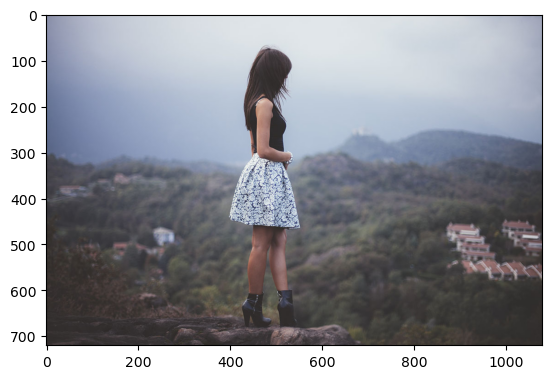

1/1 [==============================] - 0s 89ms/step
모델 출력: 1.0
hh_image_1.jpg는 사람입니다.
--------------------


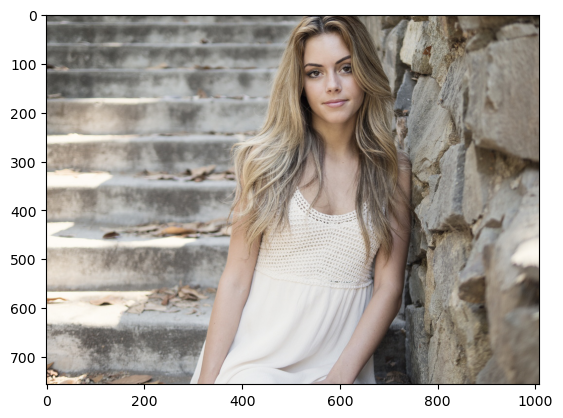

1/1 [==============================] - 0s 53ms/step
모델 출력: 1.0
hh_image_2.jpg는 사람입니다.
--------------------


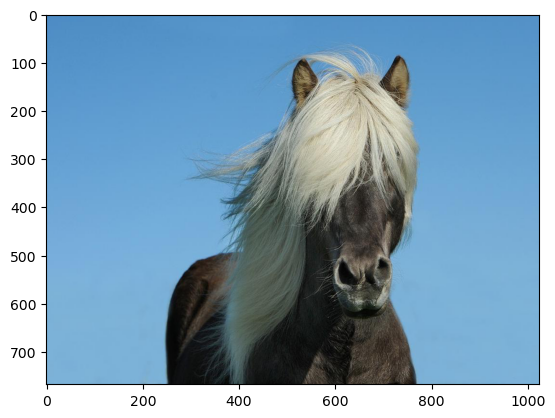

1/1 [==============================] - 0s 49ms/step
모델 출력: 1.0
hh_image_3.jpg는 사람입니다.
--------------------


In [34]:
fn = sample_images[1]
plt.imshow(mpimg.imread(fn))
plt.show()

# 이미지 불러오기
img = tf.keras.utils.load_img(fn, target_size=(300, 300))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)

classes = model.predict(x)

print('모델 출력:', classes[0][0])
if classes[0][0] > 0.5:
    print(fn + "는 사람입니다.")
else:
    print(fn + "는 말입니다.")

#### `image_dataset_from_directory` 사용하기 (최신버전)
케라스는 이미지 전처리 층을 제공해준다.   
Rescaling / RandomRotation / RandomTranslation / RandomZoom / RandomFlip   
rotation, translation, zoom 의 매개변수에 fill_mode를 'nearest'로 지정해준다.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    image_size=(300, 300),
    label_mode='binary'
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(300, 300),
    label_mode='binary'
)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(300, 300, 3)),
    tf.keras.layers.RandomRotation(0.11, fill_mode='nearest'),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomFlip('horizontal'),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

model.fit(train_ds,
          epochs=15,
          validation_data=validation_ds)

Epoch 1/15


33/33 [==============================] - 12s 260ms/step - loss: 0.7206 - accuracy: 0.5979 - val_loss: 1.1115 - val_accuracy: 0.5000
Epoch 2/15
33/33 [==============================] - 10s 265ms/step - loss: 0.6670 - accuracy: 0.7186 - val_loss: 0.4866 - val_accuracy: 0.7070
Epoch 3/15
33/33 [==============================] - 9s 256ms/step - loss: 0.5330 - accuracy: 0.7439 - val_loss: 3.3148 - val_accuracy: 0.5352
Epoch 4/15
33/33 [==============================] - 9s 257ms/step - loss: 0.5517 - accuracy: 0.7683 - val_loss: 1.2169 - val_accuracy: 0.5469
Epoch 5/15
33/33 [==============================] - 9s 257ms/step - loss: 0.4048 - accuracy: 0.8033 - val_loss: 1.9027 - val_accuracy: 0.6836
Epoch 6/15
33/33 [==============================] - 9s 258ms/step - loss: 0.3444 - accuracy: 0.8647 - val_loss: 4.2177 - val_accuracy: 0.5430
Epoch 7/15
33/33 [==============================] - 9s 255ms/step - loss: 0.3449 - accuracy: 0.8734 - val_loss: 1.3812 - val_accuracy: 0.7500
Epoch 8/15
33/3

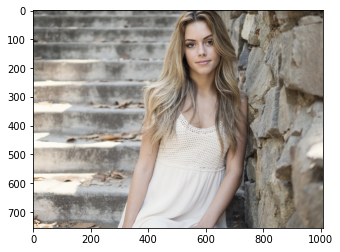

1/1 [==============================] - 0s 81ms/step
모델 출력: 0.84795827
/content/hh_image_2.jpg는 사람입니다.


In [ ]:
fn = sample_images[1]
plt.imshow(mpimg.imread(fn))
plt.show()

# 이미지 불러오기
img = tf.keras.utils.load_img(fn, target_size=(300, 300))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)

classes = model.predict(x)

print('모델 출력:', classes[0][0])
if classes[0][0] > 0.5:
    print(fn + "는 사람입니다.")
else:
    print(fn + "는 말입니다.")

## 전이 학습 (Transfer Learning)
이전에 미리 학습된 모델의 파라미터를 새로운 모델에 재학습   
* 모델의 성능을 향상시키는 방법으로, 다른 곳에서 이미 학습한 특성을 사용하는 것이다.

* Inception 버전 3 모델   
=> ImageNet 데이터베이스 안에 있는 수백만 개 이상의 이미지에서 이미 훈련된 모델
=> 수 십개의 층이 있고, 이미지를 수천 개의 클래스로 분류할 수 있다.

* 사전 훈련된 가중치를 담은 모델을 사용하는 법
1. 모델에서 가중치를 다운로드하고(urlretrieve(weights_url, weights_file)),
2. Inception V3 모델(InceptionV3())을 만들어 이 가중치를 로드(load_weights())

In [24]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),  # input_shape를 150 x 150으로 설정하였다.
                                include_top=False,
                                weights=None)               # 가중치 없는 모델 만들기
pre_trained_model.load_weights(weights_file)

In [25]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d_15[0][0]']              
 alization)                                                                                       
                                                                                       

수 천개의 클래스로 훈련된 기존 모델을 사용할 수 있지만,   
기존 신경망의 일부를 버리고 **두 개의 클래스를 분류하는 층**을 추가할 수 있다.   
   
기존에 학습이 끝난 모델은 모델 구조와 함께 필터 값, 가중치, 절편을 나타내는 일련의 숫자에 불과하다.   
이를 재사용하는 것이다.

In [26]:
for layer in pre_trained_model.layers:
    layer.trainable = False             # 각 레이어를 훈련하지 못하게 False로

last_layer = pre_trained_model.get_layer('mixed7')          # 층의 출력 크기가 7 x 7인 'mixed7' 레이어를 가져와서 last_layer 변수에 지정
                                                            # 이 지점에서 (기존) 신경망을 잘라내었다.
print('마지막 층의 출력 크기: ', last_layer.output_shape)
last_output = last_layer.output                             # 마지막층의 출력(output) 꺼내오기

마지막 층의 출력 크기:  (None, 7, 7, 768)


In [27]:
# 위에서 작업한 모델 아래에 밀집층을 추가한다.

# 1. 출력을 펼쳐서 1차원으로 만듭니다. : 내 모델에 넣어주기 위한 작업
x = layers.Flatten()(last_output)
# 2. 1,204개 은닉 유닛과 렐루 활성화 함수를 사용한 완전 연결 층을 추가합니다.
x = layers.Dense(1024, activation='relu')(x)
# 3. 분류를 위해 시그모이드 함수(=이진분류)를 사용하는 최종 층을 추가합니다.
x = layers.Dense(1, activation='sigmoid')(x)

In [28]:
model = Model(pre_trained_model.input, x)       # input 층과 output 층 넣어서 내 모델 만들기

model.compile(optimizer=RMSprop(learning_rate=0.0001),  # 모델 컴파일
              loss='binary_crossentropy',
              metrics=['acc'])

# 참고: Model 객체는 metrics=['acc'], Sequential 객체는 metrics=['accuracy']를 쓴다.

In [29]:
# 이미지 데이터 불러오기

# 훈련 데이터
train_generator = train_datagen.flow_from_directory(
    training_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(150, 150)  # 크기를 줄여서 가져왔다. input값이 150 x 150 으로 설정되어 있기 때문에
)


validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [30]:
# 훈련 시키기

model.fit(train_generator,
          epochs=40,
          validation_data=validation_generator)

Epoch 1/40
52/52 [==============================] - 41s 743ms/step - loss: 0.1425 - acc: 0.9455 - val_loss: 0.0426 - val_acc: 0.9805
Epoch 2/40
52/52 [==============================] - 34s 649ms/step - loss: 0.0290 - acc: 0.9912 - val_loss: 0.0189 - val_acc: 0.9922
Epoch 3/40
52/52 [==============================] - 30s 582ms/step - loss: 0.0170 - acc: 0.9942 - val_loss: 0.0229 - val_acc: 0.9883
Epoch 4/40
52/52 [==============================] - 30s 583ms/step - loss: 0.0216 - acc: 0.9893 - val_loss: 2.6951e-04 - val_acc: 1.0000
Epoch 5/40
52/52 [==============================] - 31s 589ms/step - loss: 0.0234 - acc: 0.9922 - val_loss: 0.0447 - val_acc: 0.9805
Epoch 6/40
52/52 [==============================] - 31s 601ms/step - loss: 0.0110 - acc: 0.9981 - val_loss: 0.0167 - val_acc: 0.9961
Epoch 7/40
52/52 [==============================] - 31s 592ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 8/40
52/52 [==============================] - 31s 589ms/ste

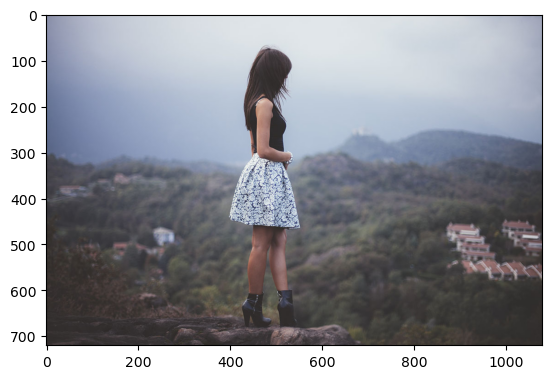

1/1 [==============================] - 0s 59ms/step
모델 출력: 1.0
hh_image_1.jpg는 사람입니다.
--------------------


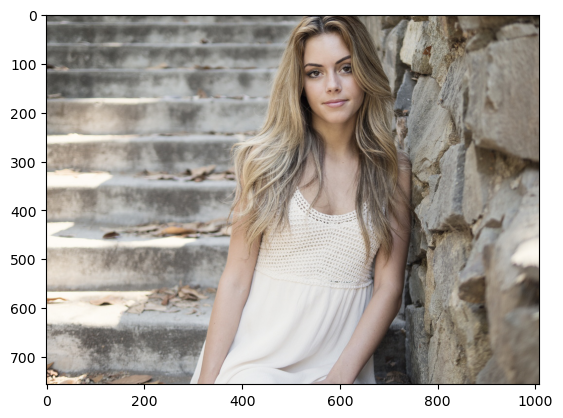

1/1 [==============================] - 0s 49ms/step
모델 출력: 1.0
hh_image_2.jpg는 사람입니다.
--------------------


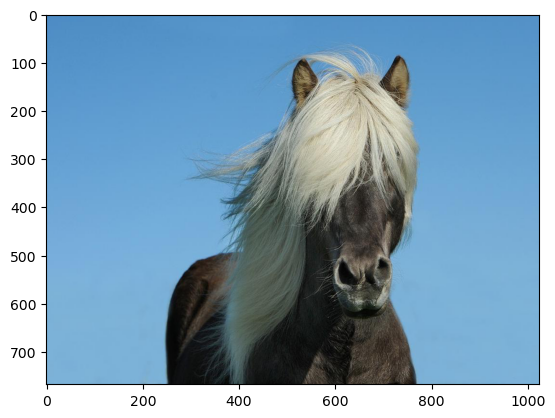

1/1 [==============================] - 0s 63ms/step
모델 출력: 1.0
hh_image_3.jpg는 사람입니다.
--------------------


In [35]:
for fn in sample_images:                                            # 이미지 리스트에서 차례로 하나씩
    # 이미지 출력: 우리 눈에 보이게
    plt.imshow(mpimg.imread(fn))
    plt.show()
    
    # 이미지 불러오기: 객체에 저장
    img = tf.keras.utils.load_img(fn, target_size=(150, 150))       # 모델에 주입하기 위해 target_size를 300 x 300으로 지정해줘야 함
    x = tf.keras.utils.img_to_array(img)                            # 이미지를 2D배열로 변환
    x = np.expand_dims(x, axis=0)                                   # 3D 배열을 넣어줘야 하므로, expand_dims 함수를 이용해 차원 추가

    classes = model.predict(x)

    print('모델 출력:', classes[0][0])
    if classes[0][0] > 0.5:
        print(fn + "는 사람입니다.")
    else:
        print(fn + "는 말입니다.")
    print('--------------------')

dogs-vs-cats 데이터셋을 사용한 예제는 원서 깃허브에 있는 [transfer_learning-cats-dogs.ipynb](https://github.com/lmoroney/tfbook/blob/master/chapter3/transfer_learning-cats-dogs.ipynb) 노트북을 참고하세요.

## 다중 분류

In [37]:
url = "https://storage.googleapis.com/learning-datasets/rps.zip"
file_name = "rps.zip"

urllib.request.urlretrieve(url, file_name)

zip_ref = zipfile.ZipFile(file_name, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [40]:
url = "https://storage.googleapis.com/learning-datasets/rps-test-set.zip"
file_name = "rps-test-set.zip"

urllib.request.urlretrieve(url, file_name)

zip_ref = zipfile.ZipFile(file_name, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [ ]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/learning-datasets/rps.zip \
#     -O ./rps.zip

In [ ]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/learning-datasets/rps-test-set.zip \
#     -O ./rps-test-set.zip

In [41]:
TRAINING_DIR = "./rps/"
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

VALIDATION_DIR = "./rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [42]:
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    class_mode='categorical'
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [44]:
model = tf.keras.models.Sequential([
    # 입력 크기는 원하는 이미지(150x150, 3채널)와 맞아야 합니다.
    # 첫 번째 합성곱 층
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', 
                           input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # 두 번째 합성곱 층
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # 세 번째 합성곱 층
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # 네 번째 합성곱 층
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # 밀집 층에 전달하기 위해 펼칩니다.
    tf.keras.layers.Flatten(),
    # 512개 뉴런을 가진 은닉층
    tf.keras.layers.Dense(512, activation='relu'),
    # 다중분류이므로, activation='softmax'
    tf.keras.layers.Dense(3, activation='softmax')
])

In [45]:
# 모델 컴파일: 손실함수는 범주형(categorical_crossentropy)으로
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])
# 참고: Model 객체는 metrics=['acc'], Sequential 객체는 metrics=['accuracy']를 쓴다.

In [46]:
model.fit(train_generator, 
          epochs=25, 
          validation_data=validation_generator)

Epoch 1/25
79/79 [==============================] - 66s 828ms/step - loss: 1.1557 - accuracy: 0.3496 - val_loss: 1.0498 - val_accuracy: 0.4543
Epoch 2/25
79/79 [==============================] - 68s 862ms/step - loss: 0.9586 - accuracy: 0.5282 - val_loss: 0.4718 - val_accuracy: 0.8898
Epoch 3/25
79/79 [==============================] - 71s 897ms/step - loss: 0.5969 - accuracy: 0.7361 - val_loss: 0.2111 - val_accuracy: 0.9758
Epoch 4/25
79/79 [==============================] - 66s 835ms/step - loss: 0.3844 - accuracy: 0.8504 - val_loss: 0.1760 - val_accuracy: 0.9005
Epoch 5/25
79/79 [==============================] - 62s 786ms/step - loss: 0.2462 - accuracy: 0.9111 - val_loss: 0.0976 - val_accuracy: 0.9543
Epoch 6/25
79/79 [==============================] - 62s 781ms/step - loss: 0.1995 - accuracy: 0.9290 - val_loss: 0.0763 - val_accuracy: 0.9946
Epoch 7/25
79/79 [==============================] - 61s 765ms/step - loss: 0.1606 - accuracy: 0.9460 - val_loss: 0.0774 - val_accuracy: 0.9651

In [47]:
# 코랩을 사용중인지 확인합니다.
if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()
    sample_images = ['/content/' + fn for fn in uploaded.keys()]

    # 업로드된 파일이 없으면 깃허브에서 다운로드합니다.
    if len(uploaded) < 1:
        import gdown
        base_url = 'https://github.com/rickiepark/aiml4coders/raw/main/ch03/'
        for i in range(1,4):
            gdown.download(base_url + 'rsp_image_{}.jpg'.format(i))
        sample_images = ['/content/rsp_image_{}.jpg'.format(i) for i in range(1,4)]

# 로컬 컴퓨터면 ch03 폴더에 있는 이미지를 사용합니다.
else:
    sample_images = ['rsp_image_{}.jpg'.format(i) for i in range(1,4)]

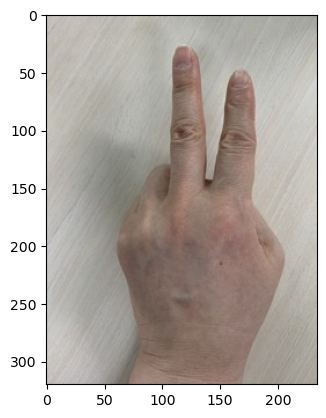

1/1 [==============================] - 0s 113ms/step
rsp_image_1.jpg는 가위입니다.


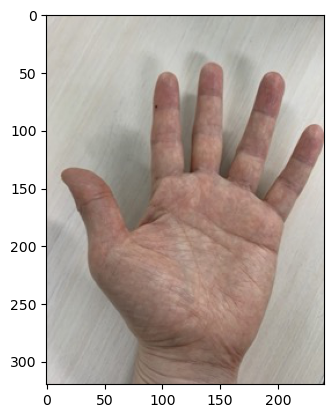

1/1 [==============================] - 0s 43ms/step
rsp_image_2.jpg는 보입니다.


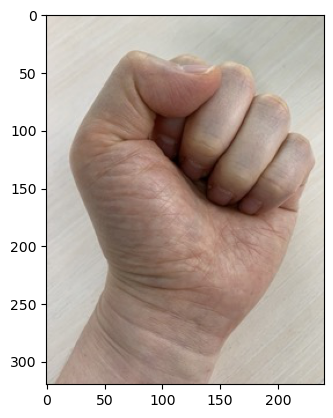

1/1 [==============================] - 0s 38ms/step
rsp_image_3.jpg는 바위입니다.


In [48]:
rsp_name = ['보', '바위', '가위']

for fn in sample_images:
    # 이미지 출력
    plt.imshow(mpimg.imread(fn))
    plt.show()
    
    # 이미지 불러오기
    img = tf.keras.utils.load_img(fn, target_size=(150, 150))
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    classes = model.predict(x)

    idx = np.argmax(classes[0])
    print(fn + "는 {}입니다.".format(rsp_name[idx]))

## 드롭아웃 규제

* 신경망을 과대적합을 방지하기 위한 목적
    
신경망을 훈련할 때 개별 뉴런은 같은 층의 다른 뉴런에 영향을 받는다.   

특히 신경망의 규모가 크다면 시간이 지남에 따라 일부 뉴런이 과도하게 전문화될 수 있다.   
이러한 특성이 이후 층에도 전달되어, 전체적으로 과대적합을 초래할 수 있다.   

또한, 이웃 뉴런이 비슷한 가중치와 절편을 가질 수 있다.   

* 드롭아웃을 사용하면 일부 뉴런을 잠시 0으로 만들어 사용하지 않고 학습할 수 있다.   
* 주로 은닉층 뒤에 드롭아웃 층을 추가한다(tf.keras.layers.Dropout(드롭아웃 비율)).

<img src="dropout.PNG" width=500>

In [ ]:
# 드롭아웃 없는 모델

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 학습은 맨 처음 가져왔던 mnist_fashion 모델
model.fit(training_images, training_labels, 
          validation_data=(test_images, test_labels),
          epochs=20)

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4859 - accuracy: 0.8243 - val_loss: 0.4027 - val_accuracy: 0.8536
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3641 - accuracy: 0.8660 - val_loss: 0.3841 - val_accuracy: 0.8577
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3302 - accuracy: 0.8766 - val_loss: 0.3656 - val_accuracy: 0.8702
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3055 - accuracy: 0.8862 - val_loss: 0.3601 - val_accuracy: 0.8723
Epoch 5/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2889 - accuracy: 0.8940 - val_loss: 0.3641 - val_accuracy: 0.8645
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2731 - accuracy: 0.8971 - val_loss: 0.3414 - val_accuracy: 0.8773
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2612 - accuracy: 0.9009 - val_loss: 0.3677 - val_accuracy:

In [ ]:
# 드롭아웃 적용한 모델

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(training_images, training_labels, 
          validation_data=(test_images, test_labels),
          epochs=20)

model.evaluate(test_images, test_labels)

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5933 - accuracy: 0.7873 - val_loss: 0.4620 - val_accuracy: 0.8308
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4321 - accuracy: 0.8454 - val_loss: 0.4163 - val_accuracy: 0.8443
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3971 - accuracy: 0.8580 - val_loss: 0.3926 - val_accuracy: 0.8576
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3749 - accuracy: 0.8654 - val_loss: 0.3749 - val_accuracy: 0.8607
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3556 - accuracy: 0.8711 - val_loss: 0.3618 - val_accuracy: 0.8730
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3412 - accuracy: 0.8759 - val_loss: 0.3576 - val_accuracy: 0.8754
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3328 - accuracy: 0.8798 - val_loss: 0.3405 - val_accuracy:

[0.3207298219203949, 0.8888000249862671]